torch.Size([100, 1, 28, 28]) torch.Size([100])


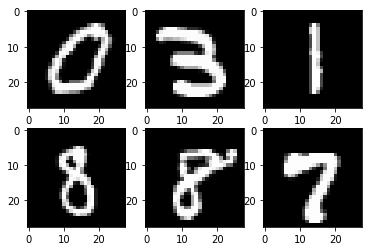

epoch 1 / 2, step 100/600, loss = 0.4425
epoch 1 / 2, step 200/600, loss = 0.3054
epoch 1 / 2, step 300/600, loss = 0.3691
epoch 1 / 2, step 400/600, loss = 0.2245
epoch 1 / 2, step 500/600, loss = 0.1805
epoch 1 / 2, step 600/600, loss = 0.3401
epoch 2 / 2, step 100/600, loss = 0.1758
epoch 2 / 2, step 200/600, loss = 0.1682
epoch 2 / 2, step 300/600, loss = 0.1372
epoch 2 / 2, step 400/600, loss = 0.1767
epoch 2 / 2, step 500/600, loss = 0.1999
epoch 2 / 2, step 600/600, loss = 0.1250
accuracy = 0.91


In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 784 # images have the size 28 x 28, we need to flatten the array to be a 1D tensor
hidden_size = 100
num_classes = 10
num_epochs = 2 # so training doesn't take too long
batch_size = 100
learning_rate = 0.001

# import MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

#create dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)

# lets have a look at one batch of this data:
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape) #print size of these and labels
#torch.Size([100, 1, 28, 28]) torch.Size([100]) this is because our batch size is 100, 1 is because there is only 1 channel 
# (no colors), the 28x28 is the image array. the 100 in torch size is each class label has 1 value

#lets plot the data
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray') # [0] is for first channel
plt.show()

# now we want to classify these digits, fully connected neural network with 1 hidden layer

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        # create layers:
        self.l1 = nn.Linear(input_size, hidden_size)
        #activation function:
        self.relu = nn.ReLU()
        # another linear layer:
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # apply all the layers
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # note we don't want an activation function at the end so no softmax (we will use cross_entropy!!)
        return out

model = NeuralNet(input_size, hidden_size, num_classes)
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training loop
# define total steps:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    # we need to loop over all the batches
    for i, (images, labels) in enumerate(train_loader): #enumerate gives us the index and the data is the tupple of images and labels
        # we need to reshape our images first, because 100, 1, 28, 28
        # input size 784, image tensor needs the size: 100, 784 (nBatches first)
        images = images.reshape(-1, 28*28).to(device) #pushes it to GPU if available
        labels = labels.to(device)
        
        #forward pass
        outputs = model(images) #gets the images
        loss = criterion(outputs, labels)
        
        #backward pass
        optimizer.zero_grad() # empties the values in the gradiant attribute
        loss.backward() #does backpropagation
        optimizer.step() #updates the parameters for us
        
        #print loss:
        if (i+1) % 100 ==0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

# testing and evaluation, we dont want to compute the gradiants for all the steps we do!
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    # loop over all the batches in the test samples
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device) #pushes it to GPU if available
        labels = labels.to(device)
        #calculate the predictions:
        outputs = model(images) #this is our trained model
        
        # torch.max will return the value and index
        _, predictions = torch.max(outputs, 1) # the _ is the class label we dont need the first value
        n_samples += labels.shape[0] # gives us the number of samples in the current batch
        n_correct = (predictions == labels).sum().item() #for each correct prediction add 1
        
    # after loop we calculate accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')
        
        
        
    

## CONVULATIONAL NEURAL NETWORKS (CNN):

They mainly work on images, apply conv filters. The pool layers learn features (latent space?) and we have 1 or more fully connected layers for the classification task
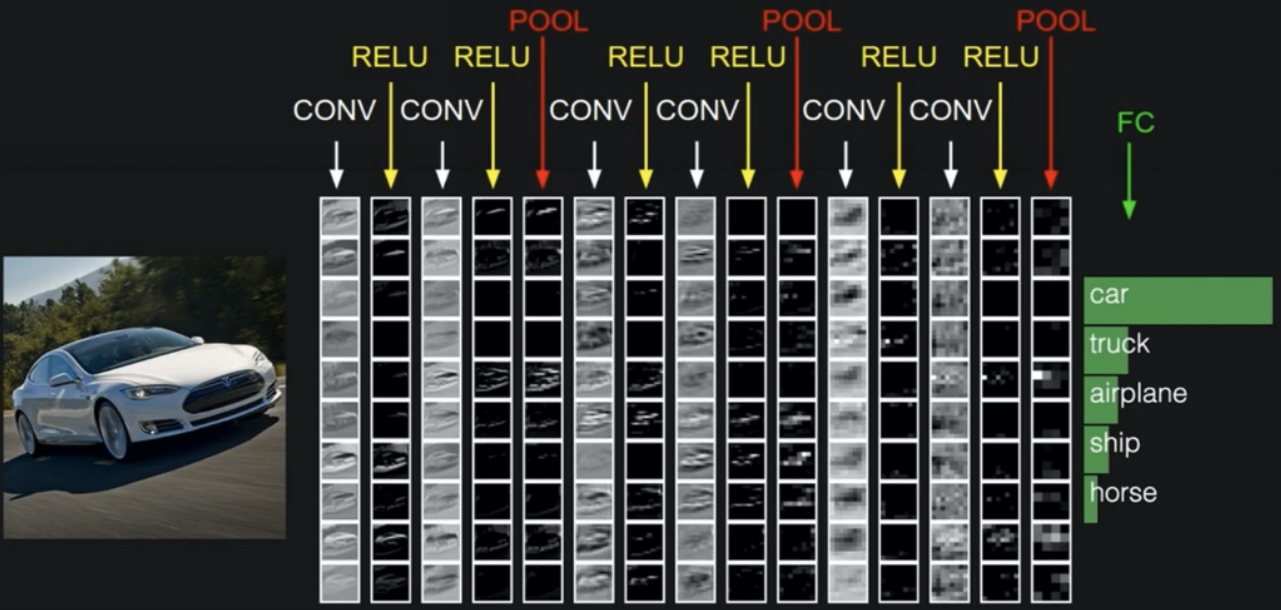

It transforms the resultant image into a smaller size, because it wont be able to fit in the corner (you can use padding).
Pooling layers: max-pooling is used to downsample an image by applying a max filter to subregions: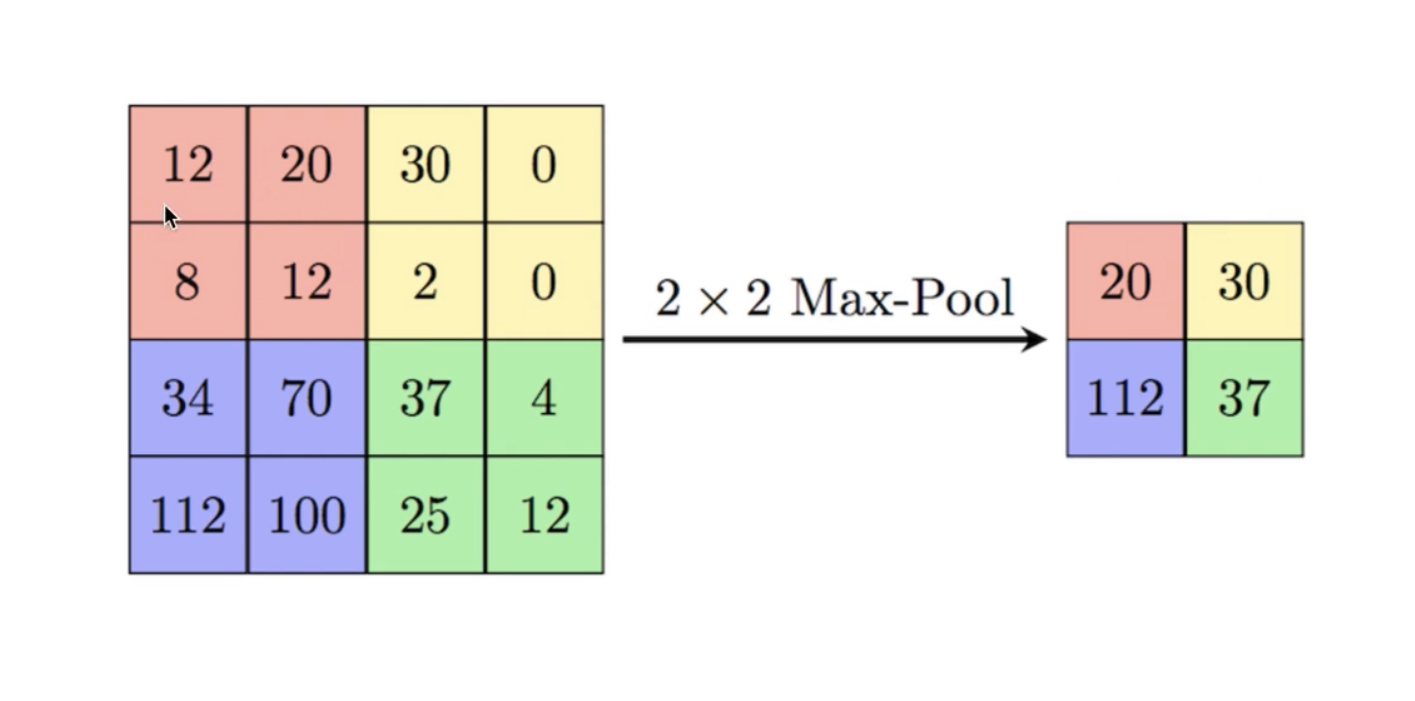
It reduces the comp. cost by reducing the size of the image, by reducing the number of parameters that our model has to learn. It also avoids overfitting by providing an abstracted form of the input.

Overview for ConvNet class:
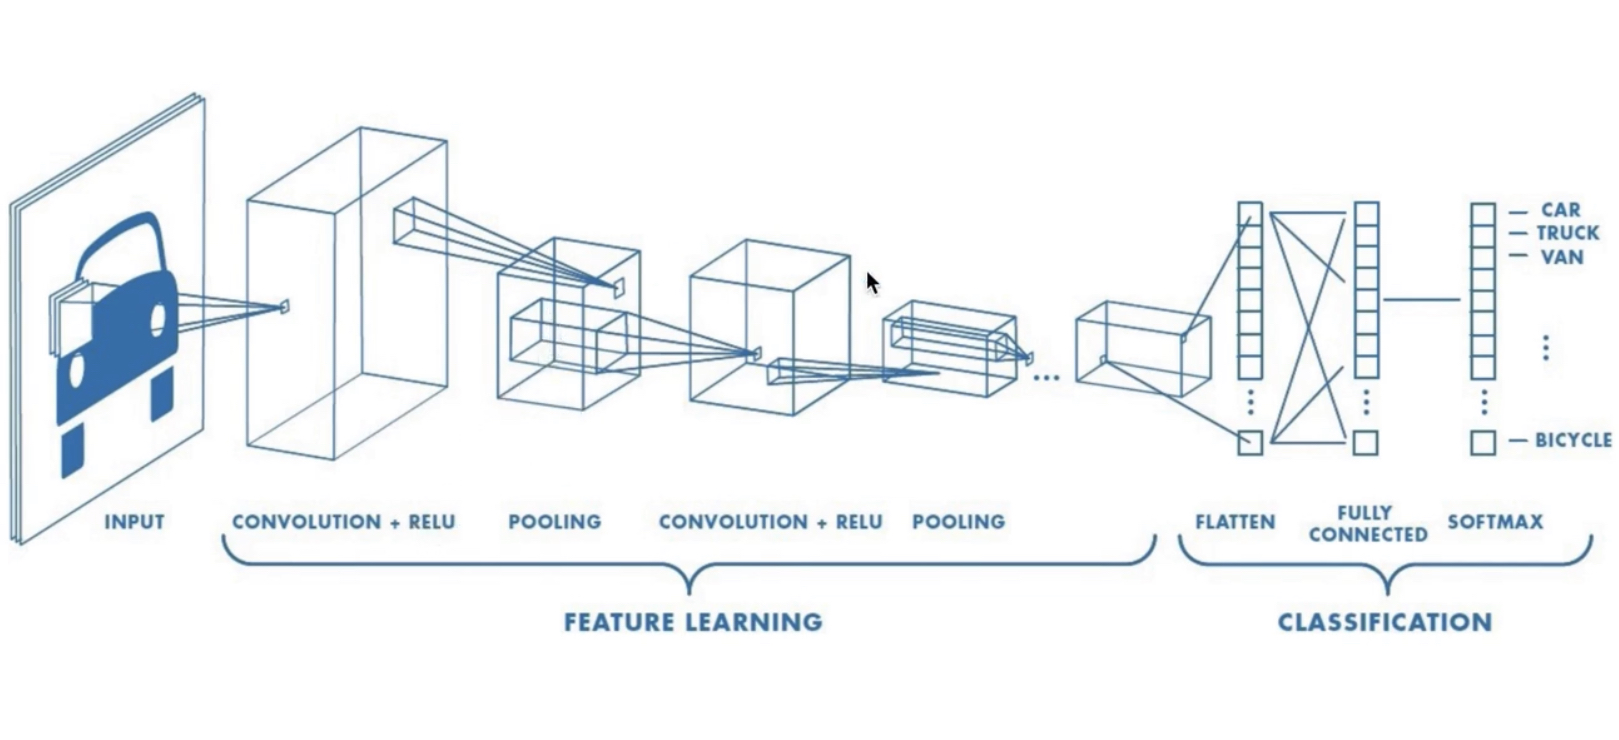

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 25
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

#implement CN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() # create layers
        self.conv1 = nn.Conv2d(3, 6, 5) # first conv layer, input channel size = 3, imgs have 3 color channels. Output 
        # size is 6 and kernel size is 5.
        self.pool = nn.MaxPool2d(2, 2) # same as in image (max pool), stride is 2 shifting 2 pixels to the right
        self.conv2 = nn.Conv2d(6, 16, 5) # must be equal to last output channel size (6) as above
        #now the fully connected layers
        # note the first must be fixed (16*5*5) and the last (10) must be fixed!
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # watch vid to understand 16 *5 *5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14 #F.relu() is the activation layer embedded in the pool layer
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5 
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400 (-1 is when we want pytorch to find it for us) view flattens img
        x = F.relu(self.fc1(x))               # -> n, 120 
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10 # no softmax, since already included in loss below.
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

## TRANSFER LEARNING:

Is a method developed in python where a model developed for a task is used as a starting point for a model on another task. We only take the last fully connected layer and modify it and train the last layer on our new data.
In this example we want to classifiy bees and ants

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True) # call the imported model

# exchange the last fully connected layers:
num_ftrs = model.fc.in_features # get numbers of features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2) # create new layer and assign it to the last layer (2 outputs for two classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# note: a scheduler updates a learning rate
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

FileNotFoundError: [Errno 2] No such file or directory: 'data/hymenoptera_data/train'

## SAVING AND LOADING MODELS

In [ ]:
import torch
import torch.nn as nn

''' 3 DIFFERENT METHODS TO REMEMBER:
 - torch.save(arg, PATH) # can be model, tensor, or dictionary
 - torch.load(PATH)
 - torch.load_state_dict(arg)
'''

''' 2 DIFFERENT WAYS OF SAVING
# 1) lazy way: save whole model
torch.save(model, PATH)
# model class must be defined somewhere
model = torch.load(PATH)
model.eval()
# 2) recommended way: save only the state_dict, used for inference, we would only need the parameters
torch.save(model.state_dict(), PATH)
# model must be created again with parameters
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''


class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_input_features=6)
# train your model...

####################save all ######################################
for param in model.parameters():
    print(param)

# save and load entire model

FILE = "model.pth"
torch.save(model, FILE)

loaded_model = torch.load(FILE)
loaded_model.eval()

for param in loaded_model.parameters():
    print(param)


############save only state dict #########################

# save only state dict
FILE = "model.pth"
torch.save(model.state_dict(), FILE)

print(model.state_dict())
loaded_model = Model(n_input_features=6)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

print(loaded_model.state_dict())


###########load checkpoint#####################
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

checkpoint = {
"epoch": 90,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
print(optimizer.state_dict())
FILE = "checkpoint.pth"
torch.save(checkpoint, FILE)

model = Model(n_input_features=6)
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0)

checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

model.eval()
# - or -
# model.train()

print(optimizer.state_dict())

# Remember that you must call model.eval() to set dropout and batch normalization layers 
# to evaluation mode before running inference. Failing to do this will yield 
# inconsistent inference results. If you wish to resuming training, 
# call model.train() to ensure these layers are in training mode.

""" SAVING ON GPU/CPU 
# 1) Save on GPU, Load on CPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)
device = torch.device('cpu')
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location=device))
# 2) Save on GPU, Load on GPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)
# Note: Be sure to use the .to(torch.device('cuda')) function 
# on all model inputs, too!
# 3) Save on CPU, Load on GPU
torch.save(model.state_dict(), PATH)
device = torch.device("cuda")
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# This loads the model to a given GPU device. 
# Next, be sure to call model.to(torch.device('cuda')) to convert the model’s parameter tensors to CUDA tensors
"""